In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [7]:
# Split features & target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [8]:
# Split features & group variables
G = X[["store_id", "store_primary_category"]]
X = X.drop(["store_id", "store_primary_category"], axis = 1)

In [9]:
# Enforce dtype of group variables
G["store_id"] = G["store_id"].astype("str") 

In [10]:
train_end = int(len(df) * 0.6)

In [11]:
val_end = train_end + int(len(df) * 0.2)

In [12]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
G_train, G_val, G_test = G[:train_end], G[train_end:val_end], G[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [13]:
# Target encoder for non-group categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "order_protocol"])

In [14]:
# Preprocess data
X_train = encoder.fit_transform(X_train, y_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

# Hyperparameter tuning

In [76]:
# Objective function
def objective_gpb(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    #max_depth = trial.suggest_int("max_depth", 2, 20) # Max depth of 20 is too restrictive for LightGBM
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_float("min_child_weight", 0.001, 20, log = True)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Create model
    model = gpb.GPBoostRegressor(
        n_jobs = 10,
        n_estimators = 5000,
        num_leaves = num_leaves,
        random_state = random_state,
        #max_depth = max_depth,
        max_depth = -1,
        min_child_samples = min_child_samples,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        colsample_bytree = colsample_bytree
    )

    # Create random effects model
    gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian"
    )
    gp_model.set_prediction_data(group_data_pred = G_val)

    # Train model with early stopping
    model.fit(
        X_train, 
        y_train,
        gp_model = gp_model, 
        eval_set = [(X_val, y_val)], 
        early_stopping_rounds = 50,
        verbose = False)

    # Report best number of rounds
    trial.set_user_attr("n_rounds", (model.best_iteration_ + 1))
    
    return model.best_score_['valid_0']['l2']


In [77]:
# Create study
study_gpb = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  study_name = "tune_gpb",
  direction = "minimize"
)

In [78]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_gpb.optimize(
  objective_gpb, 
  n_trials = 1000,
  show_progress_bar = True)

  0%|                                                                                 | 1/1000 [00:03<53:50,  3.23s/it]

[W 2023-11-23 17:33:39,811] Trial 0 failed with parameters: {'learning_rate': 0.24162824685921663, 'num_leaves': 358, 'min_child_samples': 199, 'min_child_weight': 0.0693812558119733, 'l1_reg': 6.845326871860957e-05, 'l2_reg': 0.9949814801609338, 'colsample_bytree': 0.7197282444522032} because of the following error: The value {'valid_0': OrderedDict([('l2', [816053.9061352162, 816148.896994338, 816105.967033192, 816168.2160543872, 816122.9903987874, 816163.6988574269, 816124.0176214277, 816159.7051624641, 816124.897175332, 816156.1965875751, 816125.6362430056, 816153.0838688042, 816126.2654088807, 816174.5308776877, 816121.4996447946, 816145.2573678602, 816110.6972441041, 816135.6324463972, 816113.0725007037, 816134.9850257128, 816115.1638387423, 816134.3832176157, 816116.9627391177, 816133.8308638697, 816118.5152354414, 816133.3340424637, 816119.8730890063, 816132.8682465646, 816121.0468397253, 816132.4411863178, 816111.739669649, 816134.4061372122, 816124.0850002693, 816138.86325917

  0%|▏                                                                                | 2/1000 [00:06<52:10,  3.14s/it]

[W 2023-11-23 17:33:42,880] Trial 1 failed with parameters: {'learning_rate': 0.3666627834889868, 'num_leaves': 751, 'min_child_samples': 567, 'min_child_weight': 3.48504953547459, 'l1_reg': 0.0006326488410405078, 'l2_reg': 0.3137008520978748, 'colsample_bytree': 0.418216214638642} because of the following error: The value {'valid_0': OrderedDict([('l2', [816053.9529314337, 816148.880325031, 816105.9673230144, 816168.1642628219, 816122.950317767, 816163.6133374845, 816123.9501353072, 816159.5814063228, 816124.7773204693, 816156.035827835, 816125.4836839878, 816152.8983684579, 816126.0709044937, 816174.2709156708, 816121.2671405462, 816144.9864728656, 816110.4375021666, 816135.3596017828, 816112.7860953166, 816134.700607484, 816114.8607164981, 816134.0374843464, 816116.6227690878, 816133.4765883422, 816118.1474569095, 816132.9293218201, 816119.4730123222, 816132.4383299442, 816120.6301093225, 816132.0253231211, 816111.3248772356, 816133.9541343529, 816123.6149118046, 816138.3850676792, 

  0%|▏                                                                              | 2/1000 [00:08<1:10:23,  4.23s/it]

[W 2023-11-23 17:33:45,041] Trial 2 failed with parameters: {'learning_rate': 0.2019007964177313, 'num_leaves': 665, 'min_child_samples': 187, 'min_child_weight': 8.313865828114233, 'l1_reg': 0.2168034748970178, 'l2_reg': 0.7848062539000149, 'colsample_bytree': 0.425013708779236} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\MixedEffectsRegressionDeliveryTimes\venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_30508\1398449043.py", line 38, in objective_gpb
    model.fit(
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\MixedEffectsRegressionDeliveryTimes\venv\lib\site-packages\gpboost\sklearn.py", line 841, in fit
    super().fit(X, y,
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\MixedEffectsRegressionDeliveryTimes\venv\lib\site-packages\gpboost\sklearn.py"

KeyboardInterrupt: 

In [75]:
# Save tuning log
trials_gpb = study_gpb.trials_dataframe().sort_values("value", ascending = True)
trials_gpb.to_csv("./ModifiedData/trials_gpb1.csv", index = False)

# Testing & diagnostics

In [32]:
# Load best tune
best_tune = pd.read_csv("./ModifiedData/trials_gpb1.csv").iloc[0]

In [34]:
best_tune

number                                             132
value                                      885769.6863
datetime_start              2023-11-23 17:17:02.418189
datetime_complete           2023-11-23 17:17:06.427930
duration                        0 days 00:00:04.009741
params_colsample_bytree                         0.9858
params_l1_reg                                   0.0001
params_l2_reg                                   0.1816
params_learning_rate                            0.4999
params_max_depth                                    19
params_min_child_samples                            12
params_min_child_weight                         0.0018
params_num_leaves                                  892
user_attrs_n_rounds                            27.0000
state                                         COMPLETE
Name: 0, dtype: object

In [33]:
worst_tune = pd.read_csv("./ModifiedData/trials_gpb1.csv").iloc[-2]

In [35]:
worst_tune

number                                               9
value                                      885775.5351
datetime_start              2023-11-23 17:10:09.200699
datetime_complete           2023-11-23 17:10:11.631548
duration                        0 days 00:00:02.430849
params_colsample_bytree                         0.2988
params_l1_reg                                   0.2581
params_l2_reg                                   1.8255
params_learning_rate                            0.0634
params_max_depth                                    18
params_min_child_samples                           537
params_min_child_weight                         1.1014
params_num_leaves                                  206
user_attrs_n_rounds                            25.0000
state                                         COMPLETE
Name: 160, dtype: object

In [36]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
G_train, G_test = G[:val_end], G[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [37]:
# Preprocess data
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [40]:
# Create model
model = gpb.GPBoostRegressor(
        n_estimators = int(best_tune["user_attrs_n_rounds"]),
        num_leaves = best_tune["params_num_leaves"],
        random_state = random_state,
        max_depth = best_tune["params_max_depth"],
        min_child_samples = best_tune["params_min_child_samples"],
        learning_rate = best_tune["params_learning_rate"],
        min_child_weight = best_tune["params_min_child_weight"],
        reg_alpha = best_tune["params_l1_reg"],
        reg_lambda = best_tune["params_l2_reg"],
        colsample_bytree = best_tune["params_colsample_bytree"]
    )

# Create random effects model
gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian"
    )
gp_model.set_prediction_data(group_data_pred = G_val)

# Train model with early stopping
model.fit(
        X_train, 
        y_train,
        gp_model = gp_model, 
        verbose = True)

GPBoostRegressor(colsample_bytree=0.9858111838244614,
                 learning_rate=0.4999111434024187, max_depth=19,
                 min_child_samples=12, min_child_weight=0.0018354362842255,
                 n_estimators=27, num_leaves=892, random_state=1923,
                 reg_alpha=6.081043007391805e-05,
                 reg_lambda=0.1816188115136318)

In [67]:
# Create model
model = gpb.GPBoostRegressor(
        n_estimators = 150,
        num_leaves = worst_tune["params_num_leaves"],
        random_state = random_state,
        max_depth = worst_tune["params_max_depth"],
        min_child_samples = worst_tune["params_min_child_samples"],
        learning_rate = worst_tune["params_learning_rate"],
        min_child_weight = worst_tune["params_min_child_weight"],
        reg_alpha = worst_tune["params_l1_reg"],
        reg_lambda = worst_tune["params_l2_reg"],
        colsample_bytree = worst_tune["params_colsample_bytree"]
    )

# Create random effects model
gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian"
    )
gp_model.set_prediction_data(group_data_pred = G_val)

# Train model with early stopping
model.fit(
        X_train, 
        y_train,
        gp_model = gp_model, 
        verbose = True)

GPBoostRegressor(colsample_bytree=0.2987535130068772,
                 learning_rate=0.0633923595465486, max_depth=18,
                 min_child_samples=537, min_child_weight=1.1014397999529062,
                 n_estimators=150, num_leaves=206, random_state=1923,
                 reg_alpha=0.2581409885515612, reg_lambda=1.8254768974855853)

In [68]:
# Make predictions on test data
preds = model.predict(X_test, group_data_pred = G_test)

In [69]:
preds["response_mean"]

array([2713.4451, 3142.8028, 2620.5176, 3116.2956, 2928.5311, 3054.5417,
       2712.1734, ..., 2521.8548, 3006.8645, 2307.0873, 2701.1499,
       3450.1131, 3522.3557, 2713.4392])

In [70]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["preds"] = preds["response_mean"]
df_pred["actual"] = y_test
df_pred["residual"] = y_test - preds["response_mean"]

In [71]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
1067.4653882398136
MAPE:
0.2769360717934179


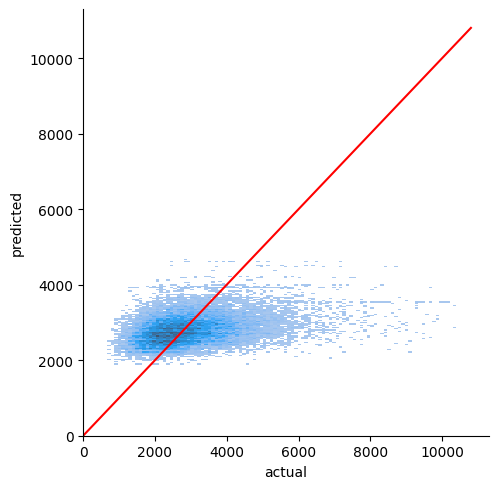

In [47]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

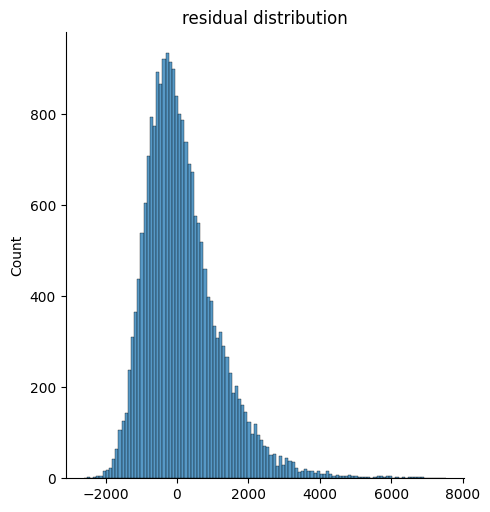

In [48]:
# Residual distribution
_ = sns.displot(df_pred["actual"] - df_pred["preds"])
_ = plt.title("residual distribution")

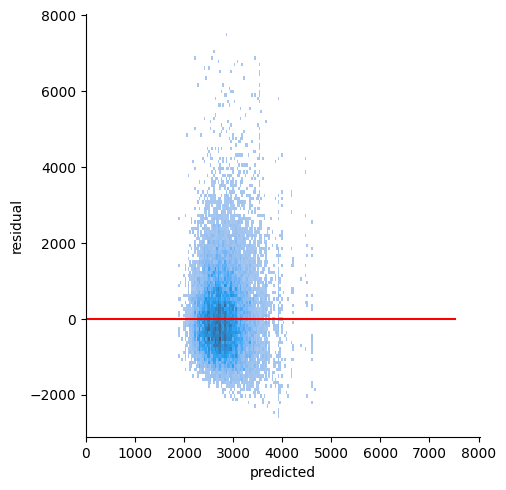

In [49]:
# Predicted vs residual
low_end = min(df_pred.residual)
max_resids = max(df_pred.residual)
_ = sns.displot(data = df_pred, x = "preds", y= "residual")
_ = plt.plot([0, max_resids], [0, 0], c = "red")
_ = plt.xlim(0, max_resids + 500)
_ = plt.ylim(low_end - 500, max_resids + 500)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

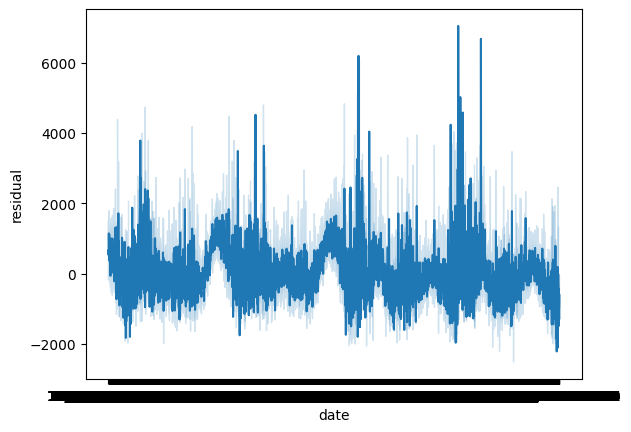

In [50]:
# Residuals across time
df_pred["date"] = df.loc[df_pred.index].created_at
_ = sns.lineplot(data = df_pred, x = "date", y = "residual")

# Inference

In [ ]:
# Feature importances
importances = pd.DataFrame({"feature": X_test.columns.values, "importance": model.feature_importances_}).sort_values("importance", ascending = False)
_ = sns.barplot(data = importances, x = "importance", y = "feature", orient = "h")

In [ ]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

In [ ]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# SHAP summary of store_primary_categories
shap.plots.scatter(shap_values[:, "store_primary_category"], color=shap_values)

In [ ]:
# EXPERIMENTAL: Plot cyclical minute feature's SHAP contributions
shap_sin = shap_values[:, "minute_sin"].values
shap_cos = shap_values[:, "minute_cos"].values
_ = sns.scatterplot(data = X_train, x = "minute_sin", y = "minute_cos", hue = (shap_sin + shap_cos))

- Bottom right: ~7AM

- Top: ~12AM

- Bottom left: ~14:30PM

# Findings
- The extreme duration orders (3+ hours) were highly impacting the model performance, and likely misleading its training. It makes sense to exclude them as the goal of the analysis is to compare XGBoost & GPBoost on equal footing. The presence of extreme outliers can cloud that comparison.
    - Also, such extremely late orders are likely late due to special reasons not captured in our feature set. This can bias the learned effects of features on duration.
- In any case, the model tends to underpredict delivery duration a bit more overall, though for durations of roughly 1500-3500 there are more overpredictions, which are the most common.
- Order date doesn't seem to be a significant factor in residuals, except for maybe daily seasonality.
- store_id is the most important feature. Makes sense since stores should have their own peculiarities that greatly affect delivery times.
- Some store categories are particularly associated with higher order durations, but most are ambiguous.
- Higher order durations around 14-15PM. Lowest after midnight hours.